## **Time Series Data Analysis on NASA's weather Data for Uttara Kannada District**
#### Manish Upadhyay (MS2024505)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')



# All parameter in csv files:
# ["T2M", "WS2M", "PRECTOTCORR", "RH2M", "ALLSKY_SFC_SW_DWN", "T2M_MIN", "T2M_MAX", "PS"]

# select Parameter to Analyse:
parameter = "T2M"

# Path for csv file:
file_path = r'Uttara_Kannada_weather_data.csv'


<a name="1."></a>
#### 1. **Data Loading and Preparation** 
 - Load Weather Dataset.
 - Setting Index filed to "datetime" field.
 - Checking for NaN and missing values.

In [10]:
# Read the CSV file into a pandas DataFrame:
df = pd.read_csv(file_path)

# Display the count of NaN values for each column
nan_count = df.isna().sum()
print("Count of NaN values in each column:\n", nan_count)

# Check if there are any NaN values in the entire dataset
has_nan = df.isna().any().any()
print("\n *** Are there any NaN values in the dataset?", has_nan)

# Set INdex field to datetime
df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['DayOfYear'].astype(str).str.zfill(3),format='%Y-%j')

# Set the date column as the index:
df = df.set_index('Date')

# check if any date-data in the file missing in between:
df['difference'] = df.index.to_series().diff().dt.days

if(df['difference']>1).any():
    print("\n *** There are missing dates in the dataset")
else:
    print("\n *** There are no missing dates in the dataset")


#plt.figure(figsize=(20, 5))
#plt.plot(df['difference'], color='blue',linestyle='dotted', lw=1, alpha=0.8)
#major_ticks = np.arange(-5, 5, 1)
#plt.xticks(pd.date_range(start="2020-01-01", end="2023-12-31", freq="M"))
#plt.xticks(rotation=90, fontweight='light',  fontsize='x-small')
#plt.yticks(major_ticks)
#plt.title("differnce between consecutive date/index")
#plt.show() 

#Ans: Data doesn't have any null and missing values

Count of NaN values in each column:
 Year                 0
DayOfYear            0
T2M                  0
WS2M                 0
PRECTOTCORR          0
RH2M                 0
ALLSKY_SFC_SW_DWN    0
T2M_MIN              0
T2M_MAX              0
PS                   0
dtype: int64

 *** Are there any NaN values in the dataset? False

 *** There are no missing dates in the dataset


<a name="2."></a> 
### 2. **Exploratory Data check**

 - Plot the time series.
 - Checking for Outlier. Finding number of Outlier
 - Treating Outlier

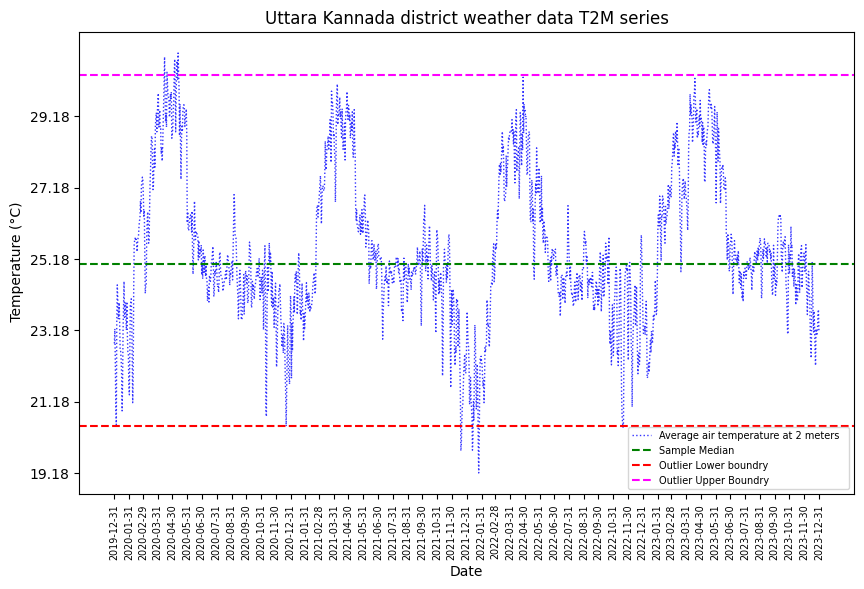

In [11]:
# Plot original Time series:
plt.figure(figsize=(10, 6))
plt.plot(df[parameter], color='blue',linestyle='dotted', lw=1, alpha=0.8, label="Average air temperature at 2 meters  ")


plt.title("Uttara Kannada district weather data T2M series")

min = df[parameter].min()
max = df[parameter].max()
major_ticks = np.arange(min, max, 2)
plt.xticks(pd.date_range(start="2019-12-31", end="2023-12-31", freq="M"))
plt.xticks(rotation=90, fontweight='light',  fontsize='x-small')
plt.yticks(major_ticks)

# Take Mean of T2M coloumn: °C (Degrees Celsius) — Average air temperature at 2 meters.
mean = df[parameter].mean()
variance = df[parameter].var()
median = df[parameter].median()  


# 25th Percentile (Q1): 25% of the data is below this value.
# 50th Percentile (Median, Q2): 50% of the data is below this value.
# 75th Percentile (Q3): 75% of the data is below this value.
q1, q3 = np.percentile(df[parameter],[25,75])

# Using Interquartile Range (IQR) Method to define boundry for outliers:
# IQR measures the spread of the middle 50% of the data (between the 25th percentile, Q1, and the 75th percentile, Q3)
# For a normal distribution, approximately 99.3% of the data lies within 1.5 times the IQR from Q1 and Q3.
IQR = q3 - q1
Lower_boundry = q1 - 1.5*IQR 
Upper_boundry = q3 + 1.5*IQR
bound = [Lower_boundry, Upper_boundry]

plt.axhline(median, color='green', linestyle='--', label='Sample Median')
plt.axhline(Lower_boundry, color='red', linestyle='--', label='Outlier Lower boundry')
plt.axhline(Upper_boundry, color='magenta', linestyle='--', label='Outlier Upper Boundry')
plt.legend(loc='lower right',prop={'size': 7})
plt.ylabel(" Temperature (°C)")
plt.xlabel("Date")
#plt.grid()
plt.show()



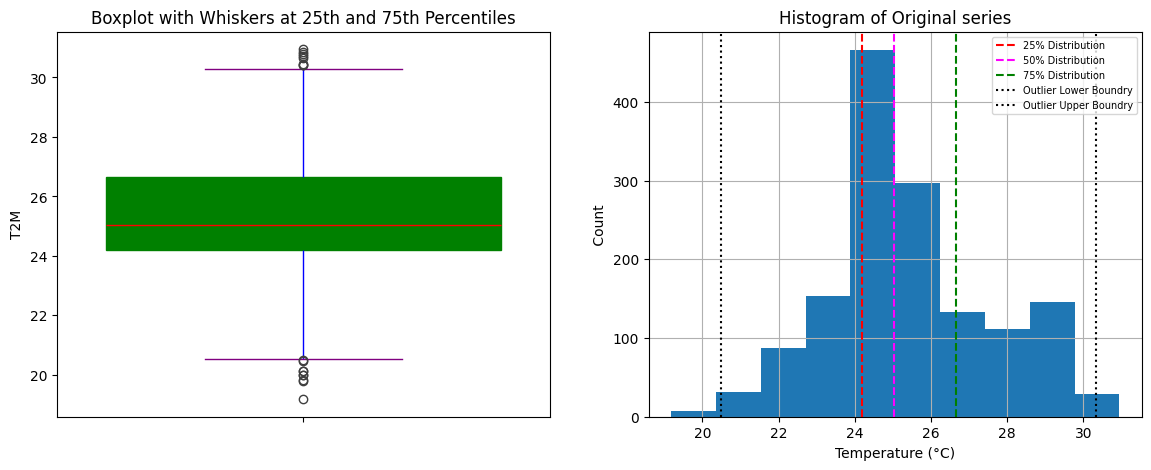

No. of Total Outliers: 17


In [12]:
# Box Plot for Outlier detection:

plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)

sb.boxplot(y=df[parameter] ,
                whis=1.5,boxprops=dict(facecolor='blue', color='green'),
                whiskerprops=dict(color='blue'),
                capprops=dict(color='purple'),
                medianprops=dict(color='red'))

plt.title('Boxplot with Whiskers at 25th and 75th Percentiles')

# Histogram before Outlier removal:
plt.subplot(1,2,2)
df[parameter].hist()
plt.ylabel(" Count ")
plt.xlabel("Temperature (°C)")
plt.title("Histogram of Original series")
plt.axvline(q1, color='red', linestyle='--', label='25% Distribution')
plt.axvline(median, color='magenta', linestyle='--', label='50% Distribution')
plt.axvline(q3, color='green', linestyle='--', label='75% Distribution')
plt.axvline(Lower_boundry, color='black', linestyle='dotted', label='Outlier Lower Boundry')
plt.axvline(Upper_boundry, color='black', linestyle='dotted', label='Outlier Upper Boundry')

plt.legend(loc='upper right',prop={'size': 7})
plt.show()

plt.show()
# The Outlier are visible using Box Plot
# Make a copy of the coclumn:
df_copy = df[parameter].copy()
Outlier_count = 0

# Replace Outlier in the series using Last Observed Carried Forward:
for i in range(1, len(df_copy)):
    if ((df_copy[i] <Lower_boundry) | (df_copy[i] > Upper_boundry)):
        df_copy[i] = last_valid
        Outlier_count += 1
    else:
        last_valid = df_copy[i] 

print('No. of Total Outliers:', Outlier_count) 

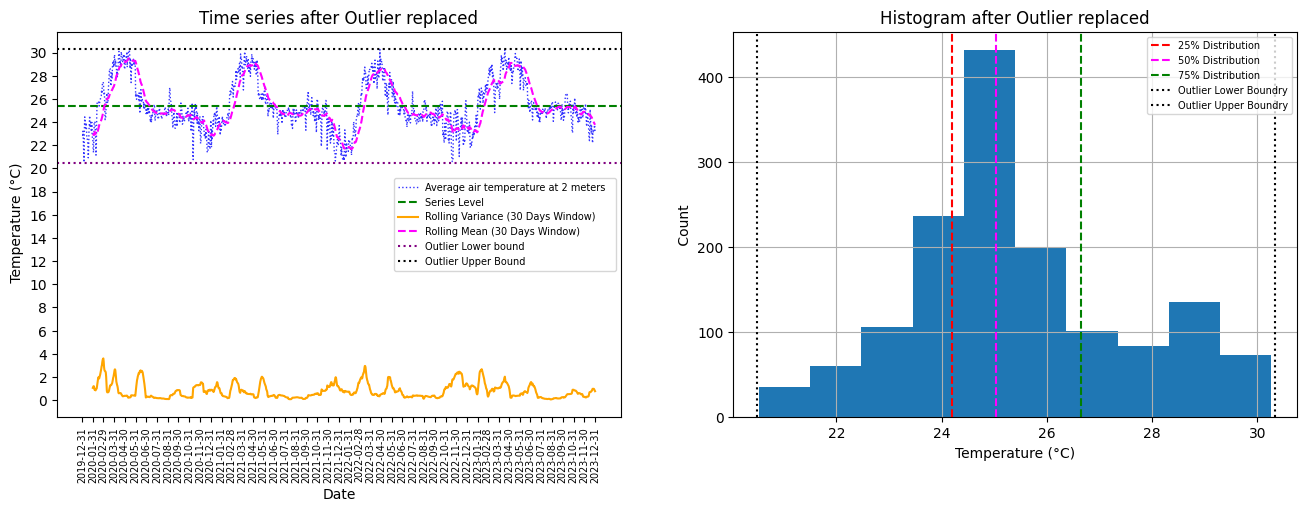

In [13]:
# Plot data and histogram with Outliers replaced:

# Add new coloumn in the original series data structure with outliers replaced:
df['No_Outlier'] = df_copy

# Plot Histogram 
plt.figure(figsize=(16, 5))

plt.subplot(1,2,2)
df_copy.hist()
plt.ylabel(" Count ")
plt.xlabel("Temperature (°C)")
plt.title("Histogram after Outlier replaced")
plt.axvline(q1, color='red', linestyle='--', label='25% Distribution')
plt.axvline(median, color='magenta', linestyle='--', label='50% Distribution')
plt.axvline(q3, color='green', linestyle='--', label='75% Distribution')
plt.axvline(Lower_boundry, color='black', linestyle='dotted', label='Outlier Lower Boundry')
plt.axvline(Upper_boundry, color='black', linestyle='dotted', label='Outlier Upper Boundry')
plt.legend(loc='upper right',prop={'size': 7})
#plt.show()

# We can see the bell curve-like shape of the Gaussian distribution in data histogram.

" *** Plot the time series and comment on the trend, variance and seasonality ************************************" 

parameter = 'No_Outlier' # Choose the coloumn with outlier treated

mean = df[parameter].mean()
variance = df[parameter].var()
window_size = 30        # 30 days or 1 month window
rolling_var = df[parameter].rolling(window=window_size).var()
rolling_mean = df[parameter].rolling(window=window_size).mean()

# Plot time series without Outlier
#plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.plot(df[parameter], color='blue',linestyle='dotted', lw=1, alpha=0.8, label="Average air temperature at 2 meters  ")
plt.axhline(mean, color='green', linestyle='--', label='Series Level')
plt.plot(rolling_var, color='orange', linestyle='-', label='Rolling Variance (30 Days Window)')
plt.plot(rolling_mean, color='magenta', linestyle='--', label='Rolling Mean (30 Days Window)')
plt.axhline(Lower_boundry, color='purple', linestyle='dotted', label='Outlier Lower bound')
plt.axhline(Upper_boundry, color='black', linestyle='dotted', label='Outlier Upper Bound')

plt.title("Time series after Outlier replaced")
major_ticks = np.arange(0, max, 2)
plt.xticks(pd.date_range(start="2019-12-31", end="2023-12-31", freq="M"))
plt.xticks(rotation=90, fontweight='light',  fontsize='x-small')
plt.yticks(major_ticks)


plt.legend(loc='best',prop={'size': 7})
plt.ylabel(" Temperature (°C)")
plt.xlabel("Date")
#plt.grid()
plt.show()



Total 17 Outliers were identified in original data using box-plot method,which includes Interquartile Range (IQR) method for boundry defining.
Outliers, beyond boundry can be seen from both the box-plot and histogram before replacement.Post repalcement both series plot and histogram shows no outlier. Rolling varaince can be seen with cleaned data showing some abrupt peaks.

<a name="3."></a> 
### 3. - Time Series Analysis 

 - Plot the time series and comment on trend, variance and seasonality
 - Perform time series decomposition.
 - Perfrom ADF Hypothesis test
 - Carried Out Differencing
 - Plot ACF and PACF
 - ARIMA Model P,D,Q values 
   

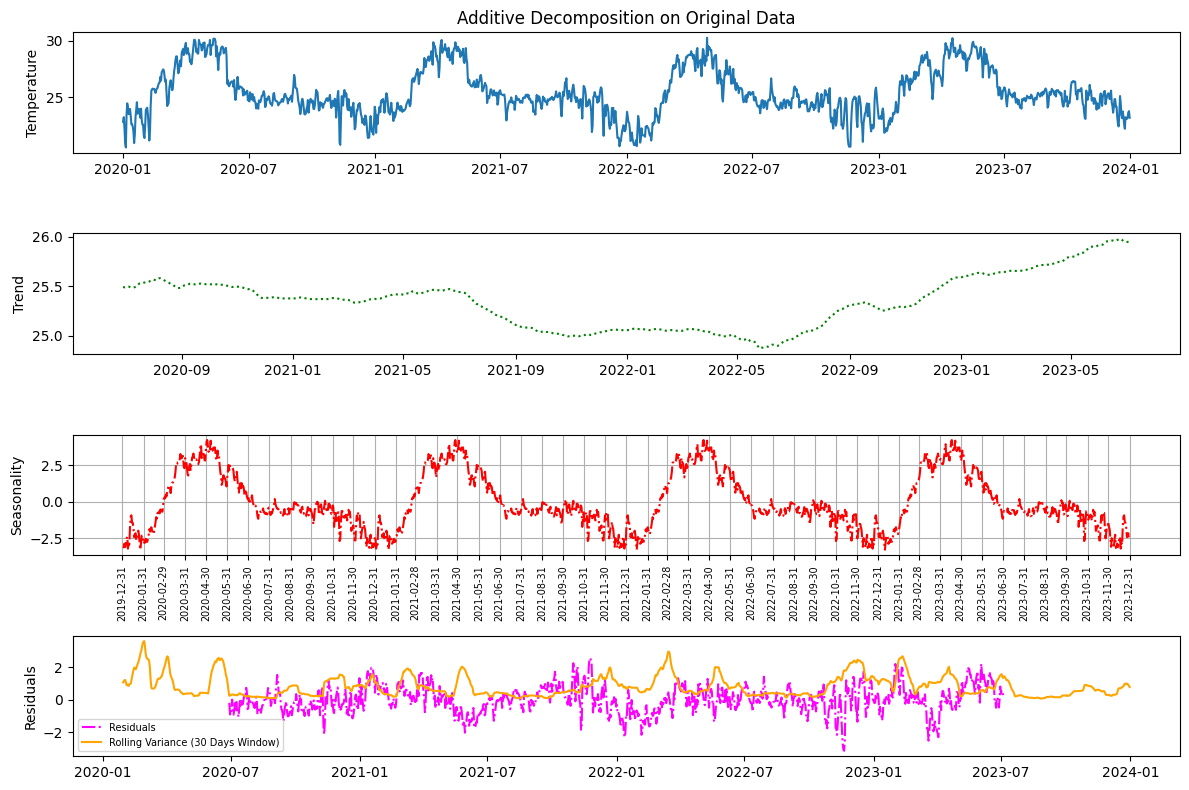

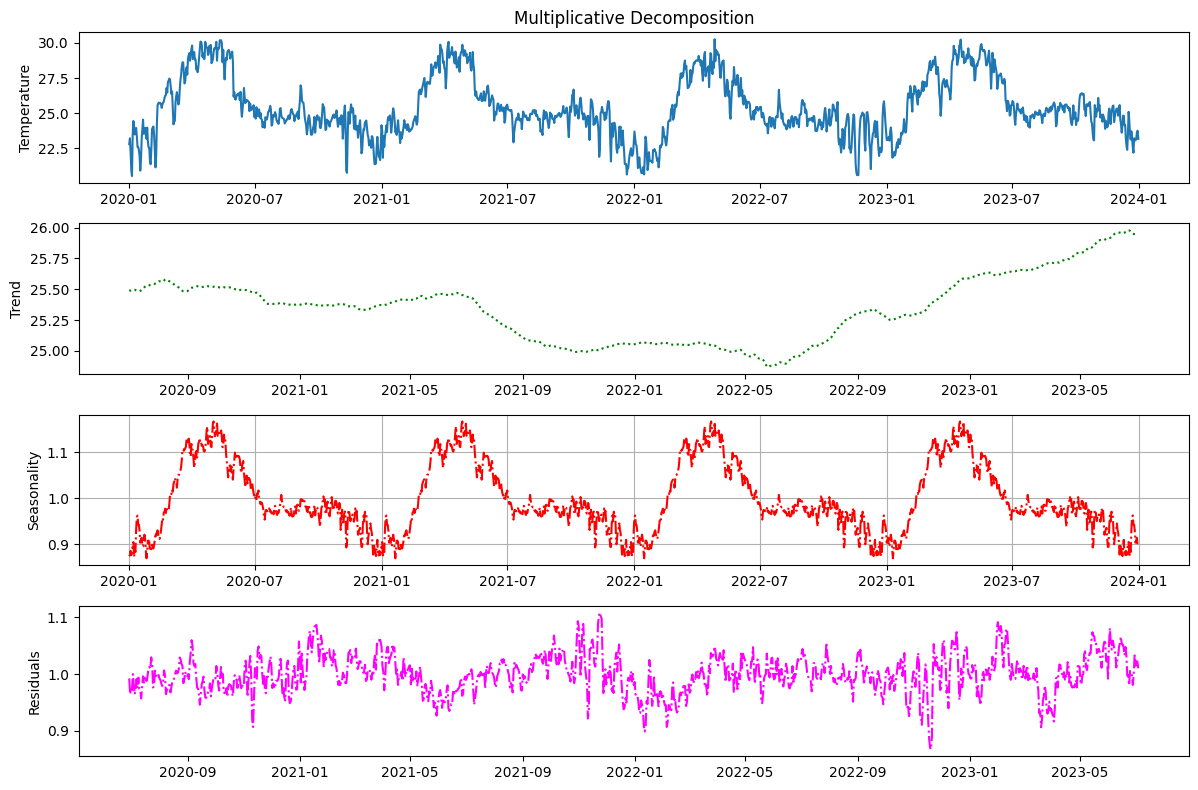

ADF Statistic: -3.254252
p-value: 0.017051
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
Reject H0 - Time series is Stationery


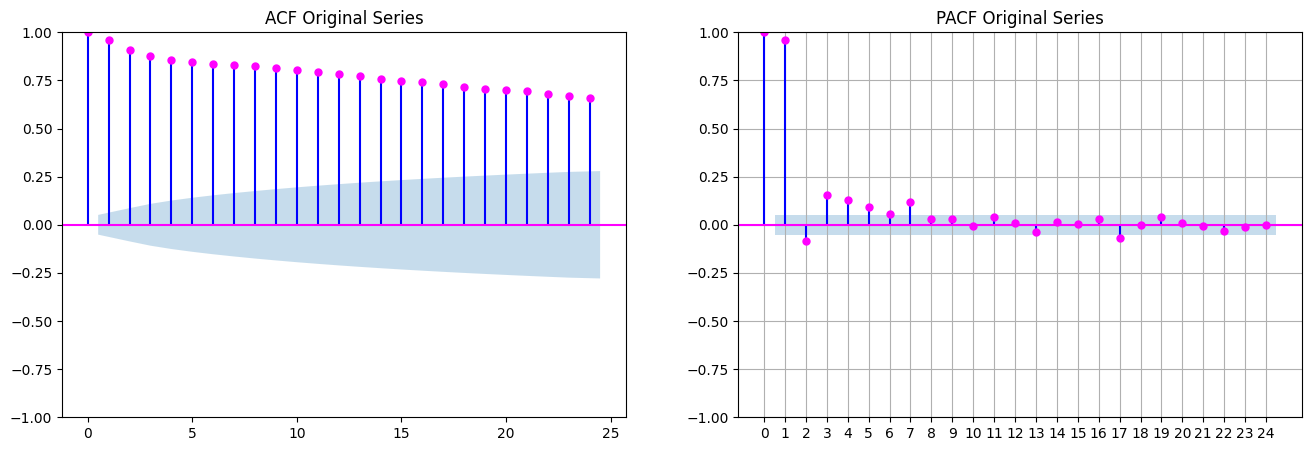

In [ ]:
"*** Decomposition on T2M outlier treated original series data *******************************************" 

parameter = 'No_Outlier'

# T2M daily data 
data  = df[parameter]

# Additive decomposition (period = 1year)
additive_decomposition = seasonal_decompose(data, model='additive',period=360)

# Multiplicative decomposition
multiplicative_decomposition = seasonal_decompose(data, model='multiplicative',period=360)

# Plotting the decompositions:
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.title('Additive Decomposition on Original Data')
plt.plot(additive_decomposition.observed, label='Original Data')
plt.ylabel("Temperature")
plt.subplot(4, 1, 2)
plt.plot(additive_decomposition.trend,color='green', label='Trend', linestyle='dotted')
plt.ylabel("Trend")
plt.subplot(4, 1, 3)
plt.plot(additive_decomposition.seasonal,color='red', label='Seasonality', linestyle='-.')
plt.ylabel("Seasonality")
plt.xticks(pd.date_range(start="2019-12-31", end="2023-12-31", freq="M"))
plt.xticks(rotation=90, fontweight='light',  fontsize='x-small')
plt.grid()
plt.subplot(4, 1, 4)
rolling_var = df[parameter].rolling(window=window_size).var()
plt.plot(additive_decomposition.resid,color='magenta', label='Residuals', linestyle='-.')
plt.plot(rolling_var, color='orange', linestyle='-', label='Rolling Variance (30 Days Window)')
plt.legend(loc='best',prop={'size': 7})
plt.ylabel("Residuals")
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.title('Multiplicative Decomposition')
plt.plot(multiplicative_decomposition.observed, label='Original Data')
plt.ylabel("Temperature")
plt.subplot(4, 1, 2)
plt.plot(multiplicative_decomposition.trend,color='green', label='Trend', linestyle='dotted')
plt.ylabel("Trend")
plt.subplot(4, 1, 3)
plt.plot(multiplicative_decomposition.seasonal,color='red', label='Seasonality', linestyle='-.')
plt.ylabel("Seasonality")
plt.grid()
plt.subplot(4, 1, 4)
plt.plot(multiplicative_decomposition.resid,color='magenta', label='Residuals', linestyle='-.')
plt.ylabel("Residuals")
plt.tight_layout()

plt.show()

" *** ADF Test-1 (Daily sampled original data) *****************************************************************************"
X = data
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
	print("Reject H0 - Time series is Stationery")
else:
	print("Failed to Reject H0 - Time series is Non-Stationery")

	""" *** Describe ACF and PACF with original series data ************************************************** """
x_ticks = np.arange(0, 25, 1)

fig, ax = plt.subplots(1,2,figsize=(16,5))
plt.grid()
plt.xticks(x_ticks)
sm.graphics.tsa.plot_acf(data, lags=24, ax=ax[0], title='ACF Original Series', color='magenta', vlines_kwargs={"colors": 'blue'})
sm.graphics.tsa.plot_pacf(data, lags=24, ax=ax[1], title='PACF Original Series',color='magenta', vlines_kwargs={"colors": 'blue'})

plt.show()
	


From decomposition (with period of 365 days) plot after the outlier replaced series above both the trend and seasoniality can be seen. Although. both up and down trend can be seen spreaded over years but series doesn't appear to be multiplicative.

In this ADF test Statistic: -3.254252 and 5% Critical value: -2.864 are in close figures. Same can be observed from strong correllation for even higher lag values in ACF plot.

Although, ADF test Stats: -3.254252 are lesser than 5% Critical value: -2.864  hence the series suggested to be weak sense Stationery
In Additon the p-value: 0.017051 is also lesser then 0.05, suggesting to reject null Hypothesis.
Looking at the both additive and multiplicative decomposiiton and ADF test we further choose to re-sample the series data to estbalish clear trend and seasonality. 

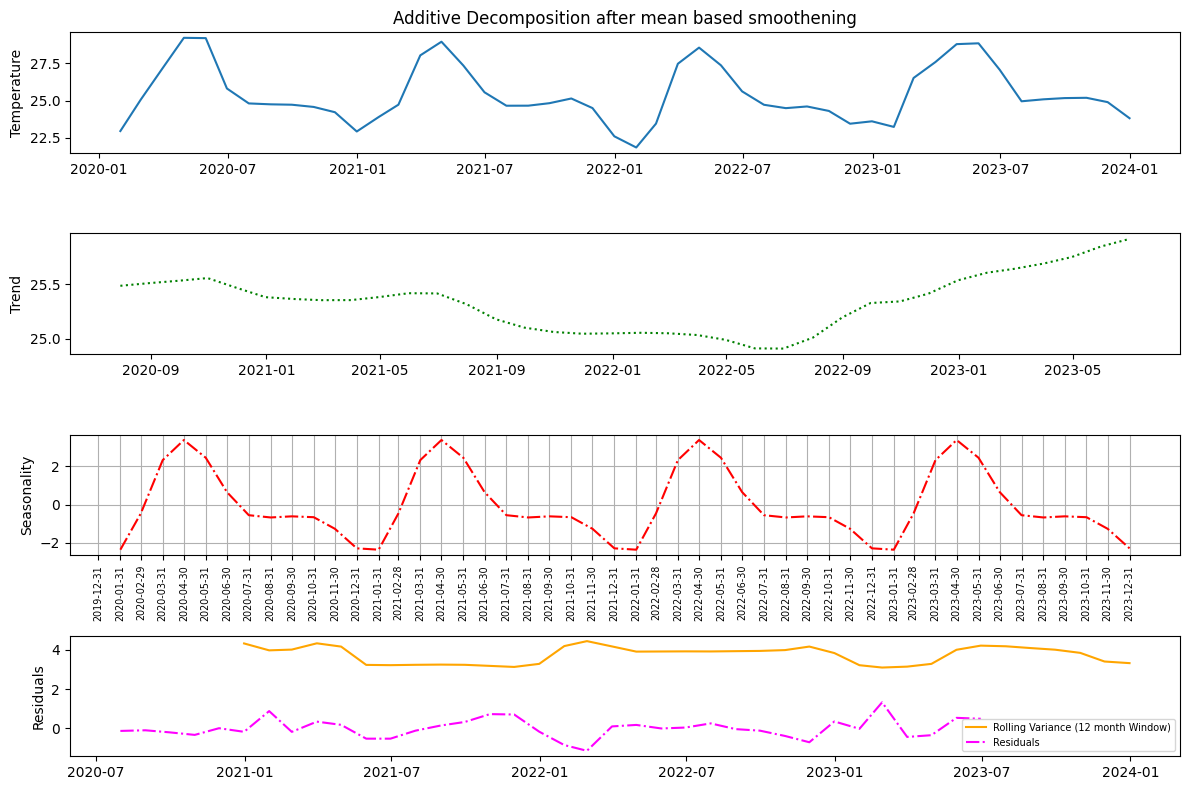

ADF Statistic: -0.237378
p-value: 0.933917
Critical Values:
	1%: -3.621
	5%: -2.944
	10%: -2.610
Failed to Reject H0 - Time series is Non-Stationery


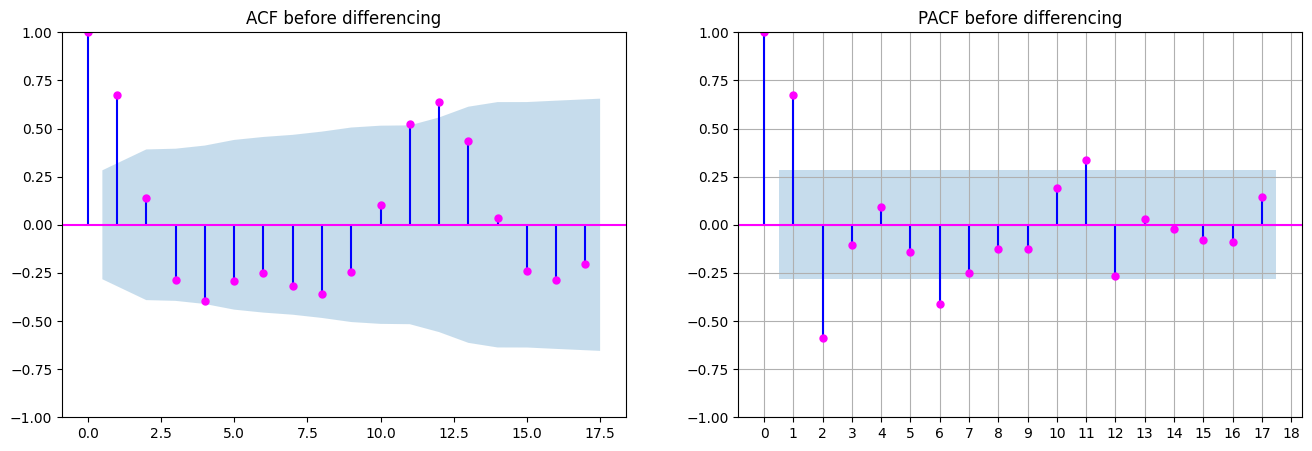

In [15]:
"*** Decomposition after Resampling T2M data from daily data to monthly data using mean based smoothening" 

parameter = 'No_Outlier'

# Resample T2M data to monthly
data_clean_monthly  = df[parameter].resample('M').mean()

# Additive decomposition
additive_decomposition = seasonal_decompose(data_clean_monthly, model='additive',period=12) 

# Plotting the decompositions:
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.title('Additive Decomposition after mean based smoothening')
plt.plot(additive_decomposition.observed, label='Original Data')
plt.ylabel("Temperature")
plt.subplot(4, 1, 2)
plt.plot(additive_decomposition.trend,color='green', label='Trend', linestyle='dotted')
plt.ylabel("Trend")
plt.subplot(4, 1, 3)
plt.plot(additive_decomposition.seasonal,color='red', label='Seasonality', linestyle='-.')
plt.ylabel("Seasonality")
plt.xticks(pd.date_range(start="2019-12-31", end="2023-12-31", freq="M"))
plt.xticks(rotation=90, fontweight='light',  fontsize='x-small')
plt.grid()
plt.subplot(4, 1, 4)
rolling_var = data_clean_monthly.rolling(window=12).var()
plt.plot(rolling_var, color='orange', linestyle='-', label='Rolling Variance (12 month Window)')
plt.plot(additive_decomposition.resid,color='magenta', label='Residuals', linestyle='-.')
plt.ylabel("Residuals")
plt.legend(loc='best',prop={'size': 7})
plt.tight_layout()
plt.show()


" *** ADF Test-2 (Monthly re-sampled data) *****************************************************************************"

X = data_clean_monthly #data.reset_index(drop=True)
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
	print("Reject H0 - Time series is Stationery")
else:
	print("Failed to Reject H0 - Time series is Non-Stationery")

""" *** Describe ACF and PACF with re-sampled monthly series data ************************************************** """
x_ticks = np.arange(0, 25, 1)

fig, ax = plt.subplots(1,2,figsize=(16,5))
plt.grid()
plt.xticks(x_ticks)
sm.graphics.tsa.plot_acf(data_clean_monthly, ax=ax[0], title='ACF before differencing', color='magenta', vlines_kwargs={"colors": 'blue'})
sm.graphics.tsa.plot_pacf(data_clean_monthly, ax=ax[1], title='PACF before differencing',color='magenta', vlines_kwargs={"colors": 'blue'})

plt.show()

# Gradual change in ACF (with high values at small lag) indicates there is positive trend in the series  
# Seasonality can be clearly seen from sinusoidal pattern is visible in ACF plot.


After resampling data with mean over monthly window, the trend and seasonality can be seen much clear/smooth .while, same Decomposition using daily data makes it noisy even with period set to 365 days. 
There is  both up and down long term change in trend but the seasonality with peaking tempearature at April and lowest at January of yearly is clearly visible from decomposition using monthly re-sampled data.

Here ADF test statistics strongly provides the indication of series became Non-stationery (after re-smapling). 
And, the p-value: 0.933917 is significantly greater then 0.05 suggesting Null Hypothesis to be True.

Now after re-sampled data, ACF and PACF shows the corrlation upto some lag values 2, while presence of sinusoid (peak appearing cyclicly at higher lag) in ACF shows the presence of seasonality in data.

Next, We will try differencing to make the series stationary for modeling.

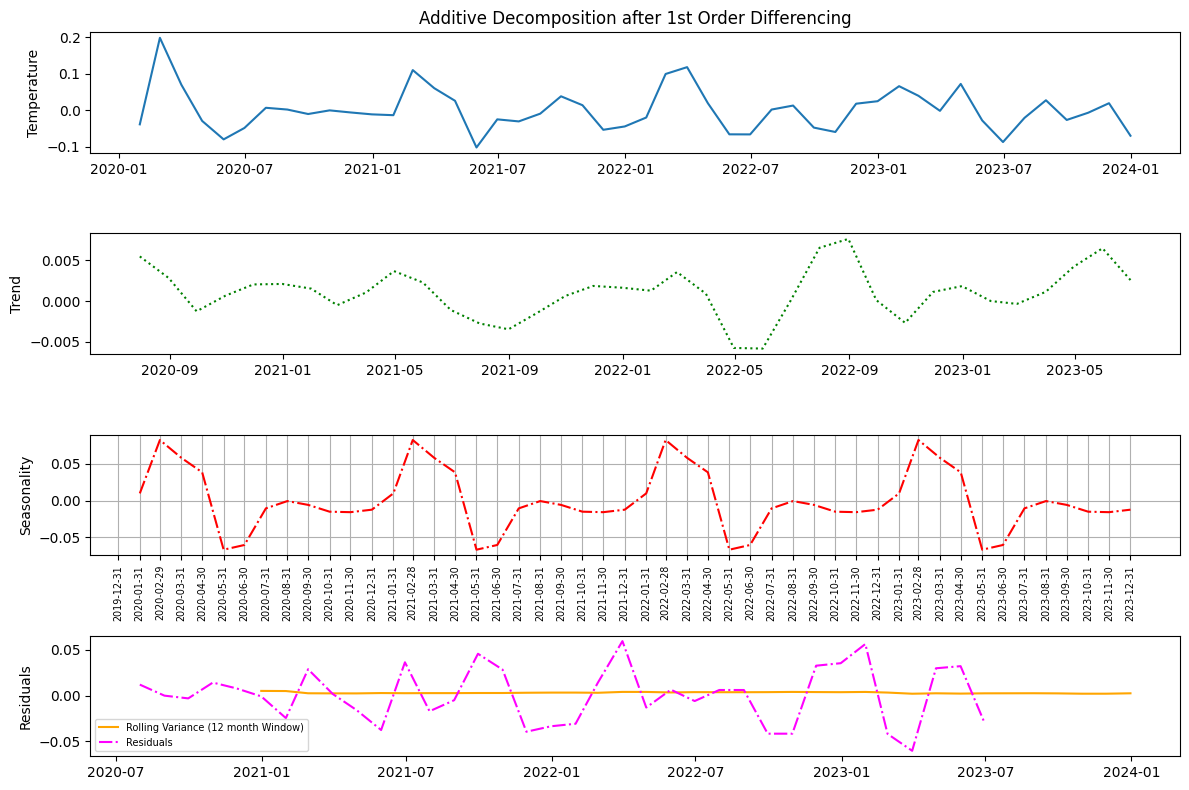

ADF Statistic: -6.413789
p-value: 0.000000
Critical Values:
	1%: -3.621
	5%: -2.944
	10%: -2.610
Reject H0 - Time series is Stationery


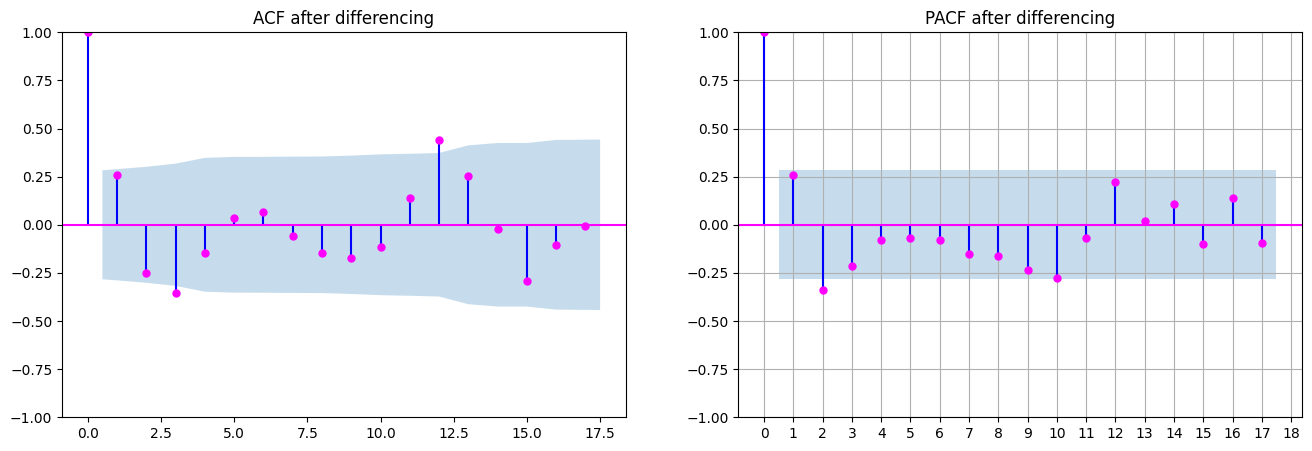

In [16]:
""" First Order Differencing in Time series with monthly re-sampled data ************************************* """
parameter = 'No_Outlier'

# First order Differenced on daily data 
diff1_data = df[parameter].diff(1)
diff1_data[0] = 0 

# Resample daily data to monthly data post differencing:
data_monthly_diff1  = diff1_data.resample('M').mean()

# Save Daily data after differencing without re-sampling:
data_daily_diff1  = diff1_data

"*** Decomposition after First Order differencing" 

# Additive decomposition
additive_decomposition = seasonal_decompose(data_monthly_diff1, model='additive', period=12) #extrapolate_trend='freq'

# Plotting the decompositions:
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.title('Additive Decomposition after 1st Order Differencing')
plt.plot(additive_decomposition.observed, label='Original Data')
plt.ylabel("Temperature")
plt.subplot(4, 1, 2)
plt.plot(additive_decomposition.trend,color='green', label='Trend', linestyle='dotted')
plt.ylabel("Trend")
plt.subplot(4, 1, 3)
plt.plot(additive_decomposition.seasonal,color='red', label='Seasonality', linestyle='-.')
plt.ylabel("Seasonality")
plt.xticks(pd.date_range(start="2019-12-31", end="2023-12-31", freq="M"))
plt.xticks(rotation=90, fontweight='light',  fontsize='x-small')
plt.grid()
plt.subplot(4, 1, 4)
rolling_var = data_monthly_diff1.rolling(window=12).var()
plt.plot(rolling_var, color='orange', linestyle='-', label='Rolling Variance (12 month Window)')
plt.legend('Rolling variance (12 month window)')
plt.plot(additive_decomposition.resid,color='magenta', label='Residuals', linestyle='-.')
plt.ylabel("Residuals")
plt.legend(loc='best',prop={'size': 7})
plt.tight_layout()
plt.show()


" *** ADF Test-3 (After first order differencing data) *****************************************************************************"

X = data_monthly_diff1
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
	print("Reject H0 - Time series is Stationery")
else:
	print("Failed to Reject H0 - Time series is Non-Stationery")


""" *** Describe ACF and PACF after first order differenced monthly sampled data ************************************************** """
x_ticks = np.arange(0, 20, 1)

fig, ax = plt.subplots(1,2,figsize=(16,5))
plt.grid()
plt.xticks(x_ticks)
sm.graphics.tsa.plot_acf(data_monthly_diff1, ax=ax[0], title='ACF after differencing', color='magenta', vlines_kwargs={"colors": 'blue'})
sm.graphics.tsa.plot_pacf(data_monthly_diff1, ax=ax[1], title='PACF after differencing',color='magenta', vlines_kwargs={"colors": 'blue'})

plt.show()
# ACF Reduced Correllation at lag-1 is evident after differencing as sign of stationarity 
# Still appearance of significant peak at 12th Lag also signifies seasonality being still present in the series


Since First order differencing is applied on the monthly re-sampled data, The series has became stationery
After differencing, the additive trend and seasonality is clearly stabilized more. 

Here ADF test statistics provides the clear indication of series turned stationery after first order differencing. 
And, the p-value: 0.0000 is smaller then 0.05 suggesting Null Hypothesis to be rejected

ACF and PACF plots shows much sharper dip then before for correlation lag. Menwhile, some peaks still can bee seen apearing at roughly same period as seasonality. The series is still weak sense stationary as clear seasaonality is visible in decomposition as well.

Variance can be clearly seen to be preety much constant after differencing across the years in comparison to before.


In [18]:
# Fit the ARIMA model with 1st order differenced data  (p=2, d=0, q=1)
model = ARIMA(data_monthly_diff1, order=(2, 0, 1))
#model = ARIMA(data_daily_diff1, order=(1, 0, 1))

model_fit = model.fit()

# Get the model summary
print(model_fit.summary())



                               SARIMAX Results                                
Dep. Variable:             No_Outlier   No. Observations:                   48
Model:                 ARIMA(2, 0, 1)   Log Likelihood                  81.014
Date:                Sun, 30 Mar 2025   AIC                           -152.028
Time:                        18:42:07   BIC                           -142.672
Sample:                    01-31-2020   HQIC                          -148.492
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.001      0.228      0.820      -0.002       0.002
ar.L1          0.9853      0.177      5.579      0.000       0.639       1.331
ar.L2         -0.5895      0.137     -4.290      0.0

First order differencing in data is included prior to doing decomposition and ACF plot shows very small correlation at lag-1 after first order differncing as a result further differencing shouldn't be required. Hence, d = 0 is expected.
The ACF and PACF plots both shows sharp drop in correlallation right at lag-1, which is inside the confidence interval itself. Still, some sinosuidal pattern is visible in both ACF and PACF plot indicating presernce of seasonality but its not signifiacnt as most of the higher lag are within confidence interval.
ACF and PACF indicates that we could use (1,0,1) order for ARIMA model but (2,0,1) seems to be giving lowest AIC and BIC while fitting.
